In [1]:
import numpy as np
import pandas as pd
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import f_oneway

pd.options.display.max_columns = 40

In [2]:
df = pd.read_csv('Data/Processed/air_data.csv', index_col=0)

categoricals = ['air_area_name', 'air_genre_name', 'day_of_week']
df[categoricals] = df[categoricals].astype('category')
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['day_of_week'] = df['day_of_week'].cat.reorder_categories(day_order, ordered=True)
df['calendar_date'] = pd.to_datetime(df['calendar_date'])
df.set_index('calendar_date', inplace=True)
df.sort_index(inplace=True)

df_processed = df.copy()
df_processed.to_pickle('Data/Processed/air_data_processed.pkl')

In [3]:
df[~df['is_test']].profile_report(plot={'histogram':{'bayesian_blocks_bins': False}})

In [4]:
rejected = ['avg_sea_pressure', 'avg_vapor_pressure', 'high_temperature', 'low_temperature']
df.drop(labels=rejected, axis=1, inplace=True)

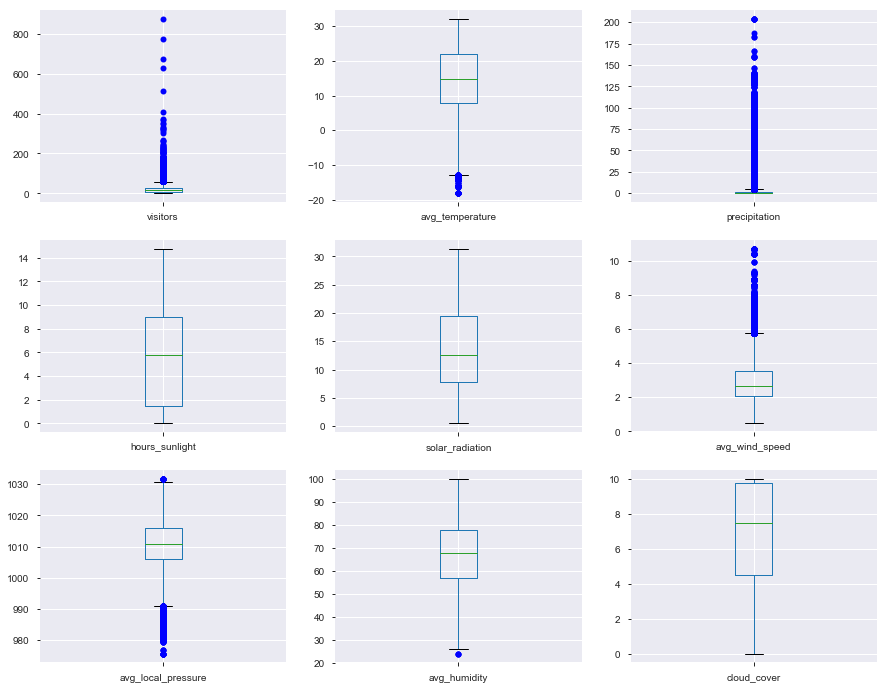

In [5]:
continuous = df.loc[:,df.dtypes == 'float64'].copy()
f, axes = plt.subplots(3, 3, figsize=(15,12))
for k, col in enumerate(continuous.columns):
    continuous.boxplot(column=col, ax=axes[k//3, k%3], sym='bo')

In [6]:
print('Visitors: ' + str(df[df['visitors']>59].iloc[:,0].count()))
print('Temperature: ' + str(df[df['avg_temperature']<-15.17].iloc[:,0].count()))
print('Precipitation: ' + str(df[df['precipitation']>5.25].iloc[:,0].count()))
print('Wind Speed: ' + str(df[df['avg_wind_speed']>5.795].iloc[:,0].count()))

Visitors: 6959
Temperature: 26
Precipitation: 48329
Wind Speed: 7065


|- |Visitors  |Temperature  |Precipitation	|Wind Speed  |  
|---|---|---|---|---| 
|Maximum|877|-18.12|204.1|10.7|  
|95%	|52|2.87|23.3|5.13|  
|Whisker|59|-15.2|5.25|5.8|  
|Count	|6,959|26|48,329|7,065|  
|Percent|2.8%|0.01%|19.2%|2.8%|  


How I will deal with outliers:  
- Temperature: No change because there are so few outside the whiskers and they are relatively close.
- Visitors and Wind Speed: I will adjust the values so that the maximum value is at the edge of the whisker.
- Precipitation: I will adjust the values so that the maximum value is the same as the 95th percentile. With >50% of the values being 0, using the end of the whiskers would mean changing 19% of the values.

In [7]:
precip95 = np.percentile(df['precipitation'], 95)
df.loc[df['precipitation'] > precip95, 'precipitation'] = precip95

In [8]:
def remove_outlier(df, col):
    quartiles = np.percentile(df[col].dropna(), [25, 75])
    iqr = quartiles[1] - quartiles[0]
    whisker = quartiles[1] + (iqr * 1.5)
    df.loc[df[col] > whisker, col] = whisker
    
remove_outlier(df, 'visitors')
remove_outlier(df, 'avg_wind_speed')

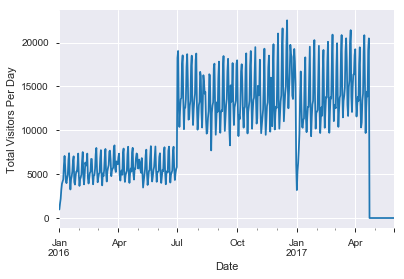

In [9]:
df.groupby(df.index)['visitors'].sum().plot()
plt.xlabel('Date')
plt.ylabel('Total Visitors Per Day')
plt.show()

It is difficult to count exactly, but there seems to be 3-5 peaks in each month which would imply that there is a weekly variation. There is also a sudden change in the number of visitors at the beginning of July.

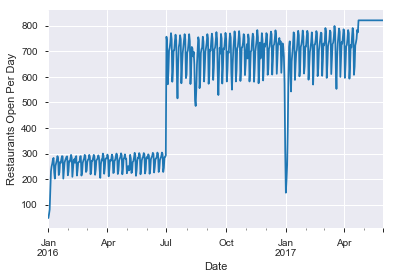

In [10]:
df.groupby(df.index)['air_store_id'].count().plot()
plt.xlabel('Date')
plt.ylabel('Restaurants Open Per Day')
plt.show()

The change in visitors starting in July corresponds to an increase in the number of restaurants.

I will start looking at average visitors to account for the change in number of restaurants.

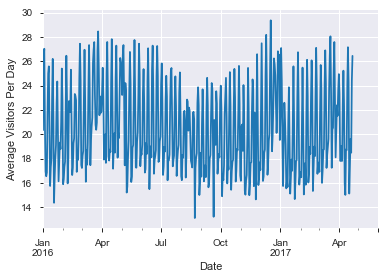

In [11]:
df.groupby(df.index)['visitors'].mean().plot()
plt.xlabel('Date')
plt.ylabel('Average Visitors Per Day')
plt.show()

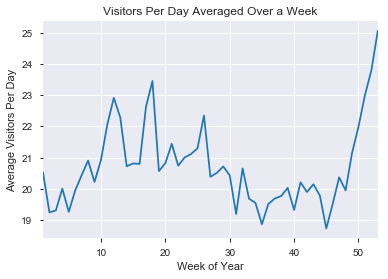

In [12]:
df.groupby(df.index.week)['visitors'].mean().plot()
plt.xlabel('Week of Year')
plt.ylabel('Average Visitors Per Day')
plt.title('Visitors Per Day Averaged Over a Week')
plt.show()

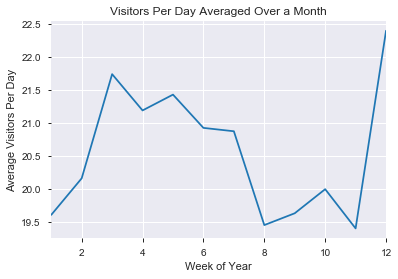

In [13]:
df.groupby(df.index.month)['visitors'].mean().plot()
plt.xlabel('Week of Year')
plt.ylabel('Average Visitors Per Day')
plt.title('Visitors Per Day Averaged Over a Month')
plt.show()

As longer time periods are averaged over, a seasonal variation becomes more apparent.

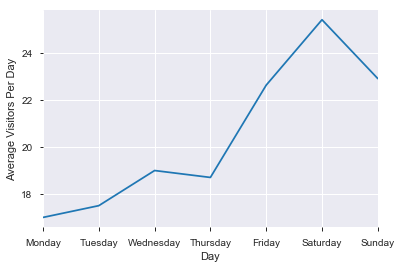

In [14]:
df.groupby(df.day_of_week)['visitors'].mean().plot()
plt.xlabel('Day')
plt.ylabel('Average Visitors Per Day')
plt.show()

The weekend has the highest number of visitors with Saturday being ~50% more than Monday.

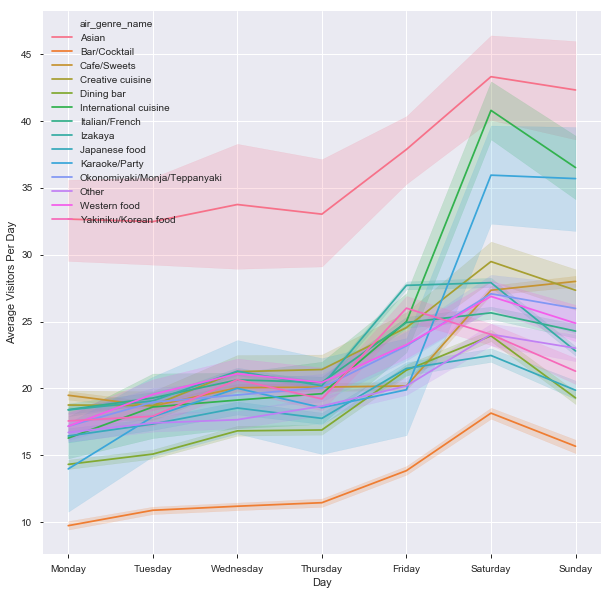

In [15]:
plt.figure(figsize=(10,10))
sns.lineplot(x=df['day_of_week'], 
             y=df['visitors'],
             hue=df['air_genre_name'])
plt.xlabel('Day')
plt.ylabel('Average Visitors Per Day')
plt.show()

There are 4 genres that behave differently than the rest.  
- Asian is consistently higher  
- Bar/Cocktail is consistently lower  
- International cuisine is similar to the rest Monday through Friday, but has a much larger increase on the weekend  
- Karaoke/Party has an even larger spike of visitors over the weekend.

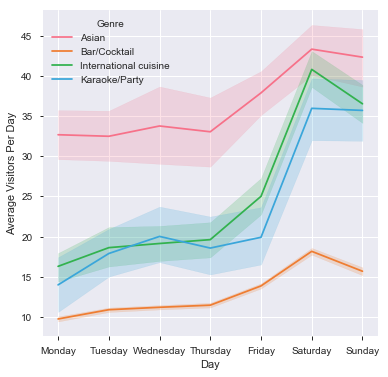

In [16]:
genre_filter = df['air_genre_name'].isin(['Asian', 'Bar/Cocktail', 'International cuisine', 'Karaoke/Party'])
plt.figure(figsize=(6, 6))
sns.lineplot(x='day_of_week', 
             y='visitors',
             hue='air_genre_name',
             legend=False,
             data=df[genre_filter])
plt.xlabel('Day')
plt.ylabel('Average Visitors Per Day')
plt.legend(['Asian', 'Bar/Cocktail', 'International cuisine', 'Karaoke/Party'], title='Genre', loc=2)
plt.show()

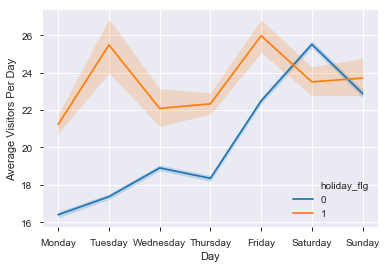

In [17]:
sns.lineplot(x='day_of_week', 
             y='visitors',
             hue='holiday_flg',
             data=df)
plt.xlabel('Day')
plt.ylabel('Average Visitors Per Day')
plt.show()

If a holiday is during the week, the number of visitors increases, but there is no increase if the holiday is on Saturday or Sunday.

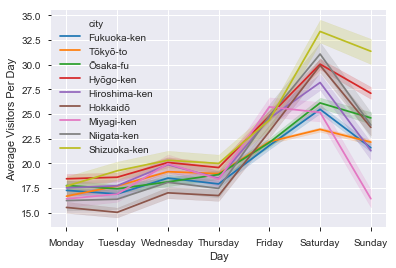

In [18]:
#plt.figure(figsize=(10,10))
sns.lineplot(x=df['day_of_week'], 
             y=df['visitors'],
             hue=df['city'])
plt.xlabel('Day')
plt.ylabel('Average Visitors Per Day')
plt.show()

City appears to have very little effect in the number of visitors.

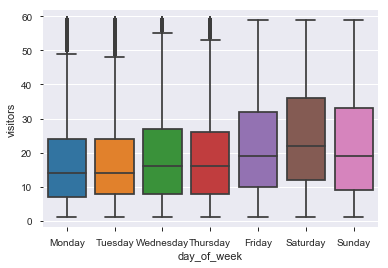

In [19]:
sns.boxplot(x='day_of_week', y='visitors', data=df)
plt.show()

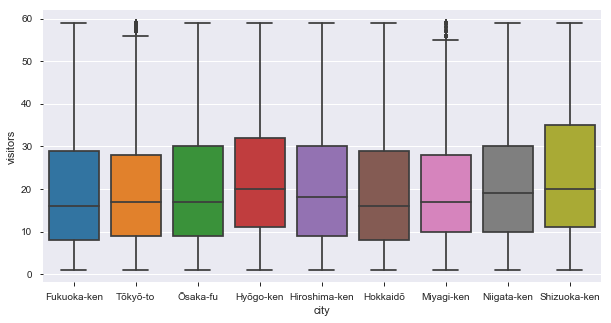

In [20]:
plt.figure(figsize=(10,5))
sns.boxplot(x='city', y='visitors', data=df)
plt.show()

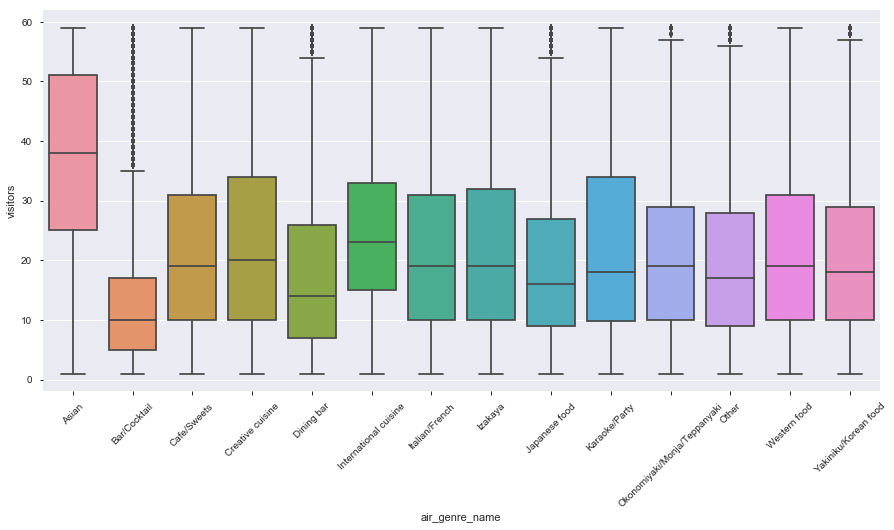

In [21]:
plt.figure(figsize=(15,7))
sns.boxplot(x='air_genre_name', y='visitors', data=df)
plt.xticks(rotation=45)
plt.show()

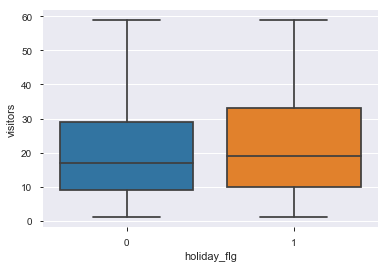

In [22]:
sns.boxplot(x='holiday_flg', y='visitors', data=df)
plt.show()

In [23]:
def anova(df, col, target='visitors'):
    samples = {}
    for group in df[col].unique():
        samples[group] = df.loc[df[col]==group, target].dropna()
    return f_oneway(*samples.values())

In [24]:
anova(df, 'day_of_week')

F_onewayResult(statistic=1778.540491276533, pvalue=0.0)

In [25]:
anova(df, 'city')

F_onewayResult(statistic=127.44189049545206, pvalue=2.5032998991961092e-214)

In [26]:
anova(df, 'air_genre_name')

F_onewayResult(statistic=822.9118292577987, pvalue=0.0)

In [27]:
anova(df, 'air_area_name')

F_onewayResult(statistic=167.70875700910346, pvalue=0.0)

In [28]:
anova(df, 'holiday_flg')

F_onewayResult(statistic=330.9762891768827, pvalue=6.570099254205805e-74)

All of the categorical features have statistically significant F-test statistics. This means that for each feature there is at least one pair of categories that have different means. The only feature where this is surprising is 'city.' This can be made sense of by realizing that even though they are clustered together, the highest mean may be significantly different from the lowest because there is so much data.